# Importing Packages and Inicial Data Preview

In [1]:
# Importing packages

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from pprint import pprint

from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline
from collections import Counter

from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC

from sklearn.kernel_approximation import Nystroem
from sklearn.pipeline import make_pipeline

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier

import umap.umap_ as umap
from functools import partial

import optuna
from optuna.visualization import plot_pareto_front
import plotly

c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# loading dataset
path_3 = "datasets/diabetes_012_health_indicators_BRFSS2015.csv"

df = pd.read_csv(path_3)

In [3]:
# Removing duplicates

df.drop_duplicates(inplace = True)
print(f"Remaining duplicates: {df.duplicated().sum()}.")

# Droping columns that are not relevant for the model

columns = ["PhysHlth","Veggies","NoDocbcCost"]
df = df.drop(columns=columns)

# Split features and target
X = df.drop(columns=['Diabetes_012'])
y = df['Diabetes_012']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=4)

# Doing Standardization 

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Random Undersampling

undersample = RandomUnderSampler(sampling_strategy={0.0:35000}, random_state=23)
X_und, y_und = undersample.fit_resample(X_train_scaled, y_train)

# SMOTE ENN for oversampling/downsampling

smote_enn = SMOTEENN(random_state=22, n_jobs=-1, sampling_strategy="auto")
X_und, y_und = smote_enn.fit_resample(X_und, y_und)

tomek = TomekLinks()
X_und, y_und = tomek.fit_resample(X_und, y_und)

pca = PCA(n_components=5) 

X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

Remaining duplicates: 0.


# Models Implementation

## Testing Hyperparameter Tuning With Optuna Optimizations

### SVM Model

In [ ]:
# Defining tuning optimization for SVM

def objective_svc(trial):
    # Suggest hyperparameters to tune
    C = trial.suggest_loguniform("C", 1e-3, 100)
    gamma = trial.suggest_loguniform("gamma", 1e-4, 1e-1)
    n_components = trial.suggest_int("n_components", 200, 1000)

    # Build pipeline with these hyperparameters
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('nystroem', Nystroem(kernel='rbf', gamma=gamma, n_components=n_components, random_state=42)),
        ('clf', LinearSVC(C=C, class_weight='balanced', random_state=42, max_iter=10000)),
    ])
    
    scoring = {
        "accuracy": make_scorer(accuracy_score),
        "precision": make_scorer(precision_score, average='macro'),
        "recall": make_scorer(recall_score, average='macro'),
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Cross-validate with multiple metrics
    scores = cross_validate(pipeline, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1)
    
    return scores["test_accuracy"].mean(), scores["test_precision"].mean(), scores["test_recall"].mean()


study_svc = optuna.create_study(directions=["maximize", "maximize", "maximize"], study_name="SVC")
study_svc.optimize(objective_svc, n_trials=30)

plot_pareto_front(study_svc, target_names=["Accuracy", "Precision", "Recall"]).show()

[I 2025-05-17 21:10:01,241] A new study created in memory with name: SVC
C:\Users\PC\AppData\Local\Temp\ipykernel_14444\514835990.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 1e-3, 100)
C:\Users\PC\AppData\Local\Temp\ipykernel_14444\514835990.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform("gamma", 1e-4, 1e-1)
[W 2025-05-17 21:14:50,031] Trial 0 failed with parameters: {'C': 39.27147112536744, 'gamma': 0.06606647008313751, 'n_components': 986} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\

KeyboardInterrupt: 

### Best SVM model

In [ ]:
best_trial_svm = max(study_svc.best_trials, key=lambda t: sum(t.values))
print("SVC Best Params:", best_trial_svm.params)
print("Accuracy:", best_trial_svm.values[0])
print("Precision:", best_trial_svm.values[1])
print("Recall:", best_trial_svm.values[2])

est_trial = study_svc.best_trials[0] 

best_params = best_trial_svm.params
print("Best params:", best_params)

# Build pipeline with the best parameters
best_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('nystroem', Nystroem(kernel='rbf',
                         gamma=best_params["gamma"],
                         n_components=best_params["n_components"],
                         random_state=42)),
    ('clf', LinearSVC(C=best_params["C"],
                      class_weight='balanced',
                      random_state=42,
                      max_iter=10000))
])

# Fit the pipeline on full training data
best_pipeline.fit(X_train, y_train)

# Predict on test set
y_pred = best_pipeline.predict(X_test)

# Print classification report
print("Classification Report for Best SVC Model:")
print(classification_report(y_test, y_pred))

### RF model

In [ ]:
# Defining tuning optimization for RF

def objective_rf(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 600),
        "max_depth": trial.suggest_int("max_depth", 5, 60),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "class_weight": "balanced",
        "n_jobs": -1
    }

    model = RandomForestClassifier(**params)

    scoring = {
        "accuracy": make_scorer(accuracy_score),
        "precision": make_scorer(precision_score, average='macro'),
        "recall": make_scorer(recall_score, average='macro'),
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    scores = cross_validate(model, X_train, y_train, scoring=scoring, cv=cv)
    return scores["test_accuracy"].mean(), scores["test_precision"].mean(), scores["test_recall"].mean()

study_rf = optuna.create_study(directions=["maximize", "maximize", "maximize"], study_name="RF")
study_rf.optimize(objective_rf, n_trials=30)

plot_pareto_front(study_rf, target_names=["Accuracy", "Precision", "Recall"]).show()

### Best RF model

In [ ]:
best_trial_rf = max(study_rf.best_trials, key=lambda t: sum(t.values))
print("SVC Best Params:", best_trial_rf.params)
print("Accuracy:", best_trial_rf.values[0])
print("Precision:", best_trial_rf.values[1])
print("Recall:", best_trial_rf.values[2])

best_trial_rf = study_rf.best_trials[0]

best_params_rf = best_trial_rf.params
print("Best RF params:", best_params_rf)

# Building the RF model with the best hyperparameters
best_rf = RandomForestClassifier(
    n_estimators=best_params_rf["n_estimators"],
    max_depth=best_params_rf["max_depth"],
    min_samples_split=best_params_rf["min_samples_split"],
    min_samples_leaf=best_params_rf["min_samples_leaf"],
    class_weight="balanced",
    n_jobs=-1,
    random_state=42
)

best_rf.fit(X_train, y_train)
y_pred_rf = best_rf.predict(X_test)

# Print classification report
print("Classification Report for Best RF Model:")
print(classification_report(y_test, y_pred_rf))

### NN model

In [ ]:
# Defining tuning optimization for NN

X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)

y_train_cat = to_categorical(y_train, num_classes=3)
y_test_cat = to_categorical(y_test, num_classes=3)

def create_model(input_dim, units1, dropout1, n_layers, units_i, dropout_i, lr):
    model = Sequential()
    model.add(Dense(units1, activation="relu", input_shape=(input_dim,)))
    model.add(Dropout(dropout1))
    
    for _ in range(n_layers):
        model.add(Dense(units_i, activation="relu"))
        model.add(Dropout(dropout_i))
    
    model.add(Dense(3, activation="softmax"))
    model.compile(optimizer=Adam(learning_rate=lr),
                  loss="categorical_crossentropy",
                  metrics=["accuracy", "precision", "recall"])
    return model

def objective_nn(trial):
    units1 = trial.suggest_int("units1", 64, 256)
    dropout1 = trial.suggest_float("dropout1", 0.2, 0.5)
    n_layers = 2
    units_i = trial.suggest_int("units_i", 32, 128)
    dropout_i = trial.suggest_float("dropout_i", 0.2, 0.5)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])

    model = create_model(X_train_final.shape[1], units1, dropout1, n_layers, units_i, dropout_i, lr)

    early_stop = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

    y_train_final_cat = to_categorical(y_train_final, num_classes=3)
    y_val_cat = to_categorical(y_val, num_classes=3)

    model.fit(
        X_train_final, y_train_final_cat,
        validation_data=(X_val, y_val_cat),
        epochs=20,
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=0
    )

    y_pred_probs = model.predict(X_val)
    y_pred = np.argmax(y_pred_probs, axis=1)

    val_accuracy = accuracy_score(y_val, y_pred)
    val_precision = precision_score(y_val, y_pred, average='macro')
    val_recall = recall_score(y_val, y_pred, average='macro')

    return val_accuracy, val_precision, val_recall

study_nn = optuna.create_study(directions=["maximize", "maximize", "maximize"], study_name="NN")
study_nn.optimize(objective_nn, n_trials=30, timeout=1800)

plot_pareto_front(study_nn, target_names=["Accuracy", "Precision", "Recall"]).show()

### Best NN model

In [ ]:
# Retrieve the best trial based on the sum of multi-objective metrics
best_trial_nn = max(study_nn.best_trials, key=lambda t: sum(t.values))

print("Best NN Parameters:", best_trial_nn.params)
print("Accuracy:", best_trial_nn.values[0])
print("Precision:", best_trial_nn.values[1])
print("Recall:", best_trial_nn.values[2])

# Extract parameters
params = best_trial_nn.params
units1 = params["units1"]
dropout1 = params["dropout1"]
units_i = params["units_i"]
dropout_i = params["dropout_i"]
lr = params["lr"]
batch_size = params["batch_size"]
n_layers = 2  # fixed as per your tuning setup

# Create the best model
def create_model_for_best(input_dim, units1, dropout1, n_layers, units_i, dropout_i, learning_rate):
    model = Sequential()
    model.add(Dense(units1, activation="relu", input_shape=(input_dim,)))
    model.add(Dropout(dropout1))
    for _ in range(n_layers):
        model.add(Dense(units_i, activation="relu"))
        model.add(Dropout(dropout_i))
    model.add(Dense(3, activation="softmax"))
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss="categorical_crossentropy",
        metrics=["accuracy", "Precision", "Recall"]
    )
    return model

# Instantiate and train the best model
best_model = create_model_for_best(X_train.shape[1], units1, dropout1, n_layers, units_i, dropout_i, lr)

early_stop = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

best_model.fit(
    X_train, y_train_cat,
    validation_split=0.2,
    epochs=20,
    batch_size=batch_size,
    class_weight=class_weights,
    callbacks=[early_stop],
    verbose=0
)

y_pred_nn_probs = best_model.predict(X_test)
y_pred_nn = np.argmax(y_pred_nn_probs, axis=1)

print("Classification Report for Best NN Model:")
print(classification_report(y_test, y_pred_nn))

### Best Model Obtained

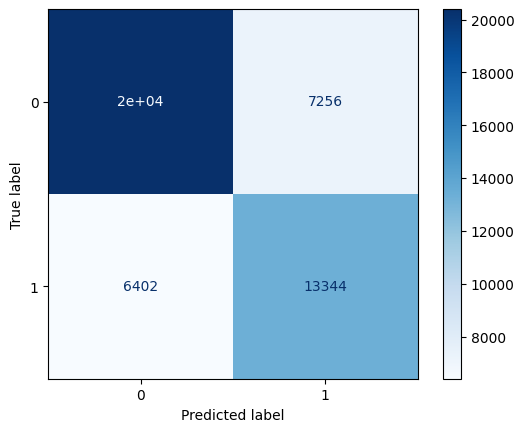

In [ ]:
# Best model and the parameters tuned
print("The best model obtained (SVC) and it's params:", best_trial_nn.params)

cm = confusion_matrix(y_test, y_pred_nn)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.show()